# Look-A-Like Model

## Dataset
- [Social Network Ads](https://www.kaggle.com/datasets/rakeshrau/social-network-ads/data) A categorical dataset to determine whether a user purchased a particular product


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline



In [59]:
palette = [ '#0077b6' , '#00b4d8' , '#90e0ef' , '#caf0f8']
# color_palette = sns.color_palette(palette)
sns.set_palette(palette)
sns.set_style('whitegrid')

In [60]:
df = pd.read_csv('../../../data/common_datasets/social_network_ads.csv')

In [61]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [62]:
df = df.set_index("User ID")

In [63]:
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})

In [64]:
df.shape

(400, 4)

In [65]:
df.Purchased.value_counts(normalize=True)

Purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 15624510 to 15594041
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Gender           400 non-null    int64
 1   Age              400 non-null    int64
 2   EstimatedSalary  400 non-null    int64
 3   Purchased        400 non-null    int64
dtypes: int64(4)
memory usage: 15.6 KB


## EDA

### Missing Values

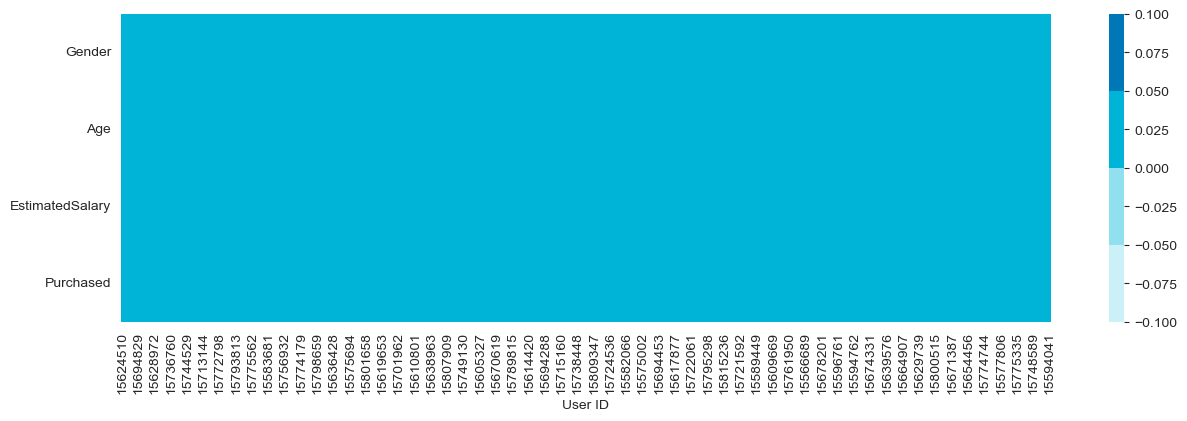

In [67]:
#Showing missing data at which index of the data
fig, ax = plt.subplots(figsize=(15,4)) 
sns.heatmap(df.isna().transpose(), ax=ax, cmap= palette[::-1] )
plt.show()

### Target Visualisation
- Visualize the nature of purchased and non-purchased customers using T-SNE. 
    - T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.

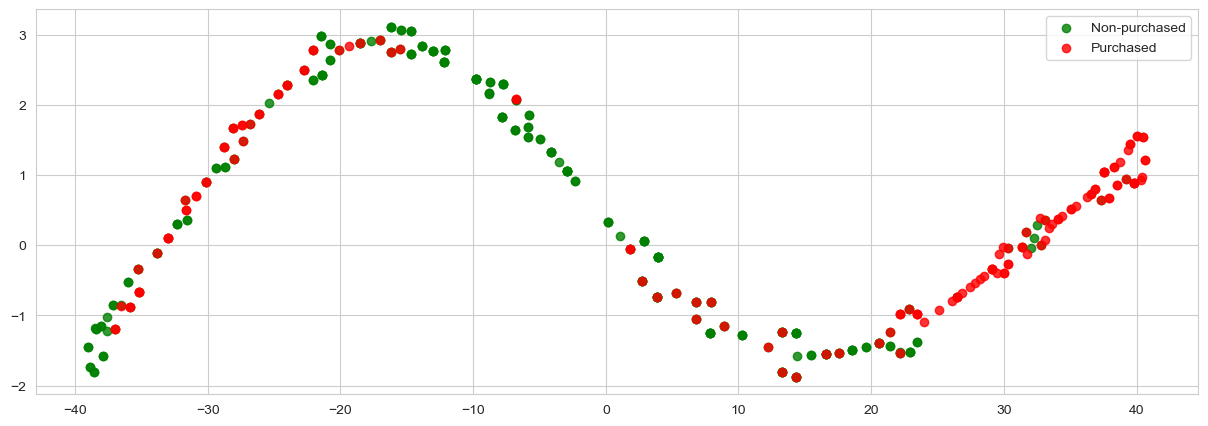

In [68]:
def tsne_plot(x, y):
    tsne = TSNE(n_components=2, random_state=2024)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(15, 5))

    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non-purchased')
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Purchased')

    plt.legend(loc='best');
    plt.show();
    
tsne_plot(x=df[["Gender","Age","EstimatedSalary"]], y=df["Purchased"])

- From the above graph we can observe that there are many non-purchased customers which are very close to purchased customers, thus are difficult to accurately classify from a model.

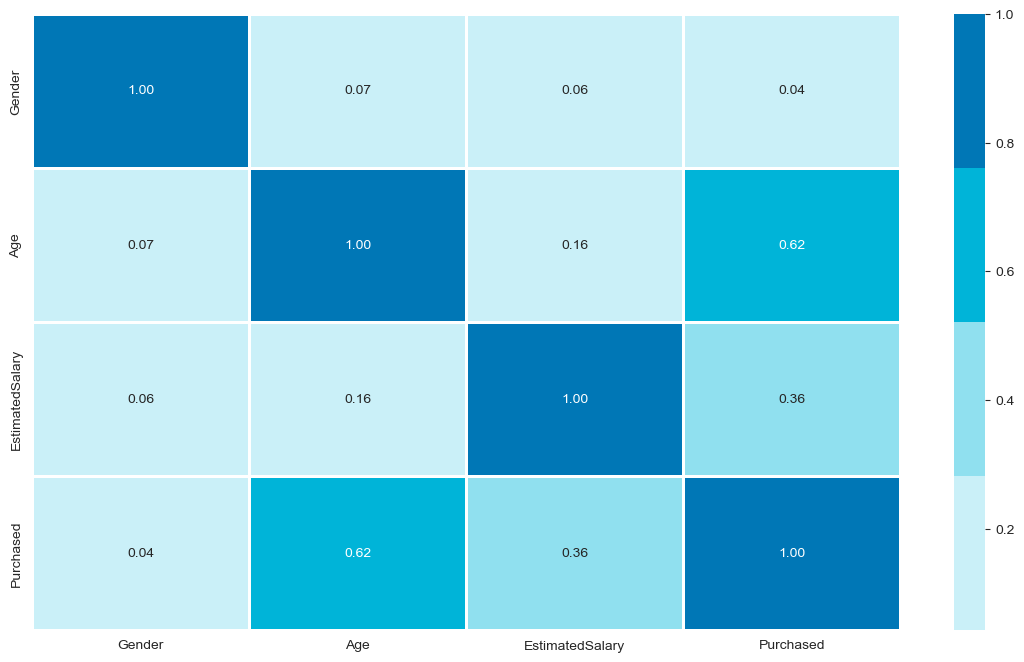

In [70]:
corr_df = df.corr()
plt.figure(figsize= (14, 8))
sns.heatmap(corr_df, annot = True, fmt = '.2f', linewidths= 0.8  , cmap=palette[::-1])
plt.show()

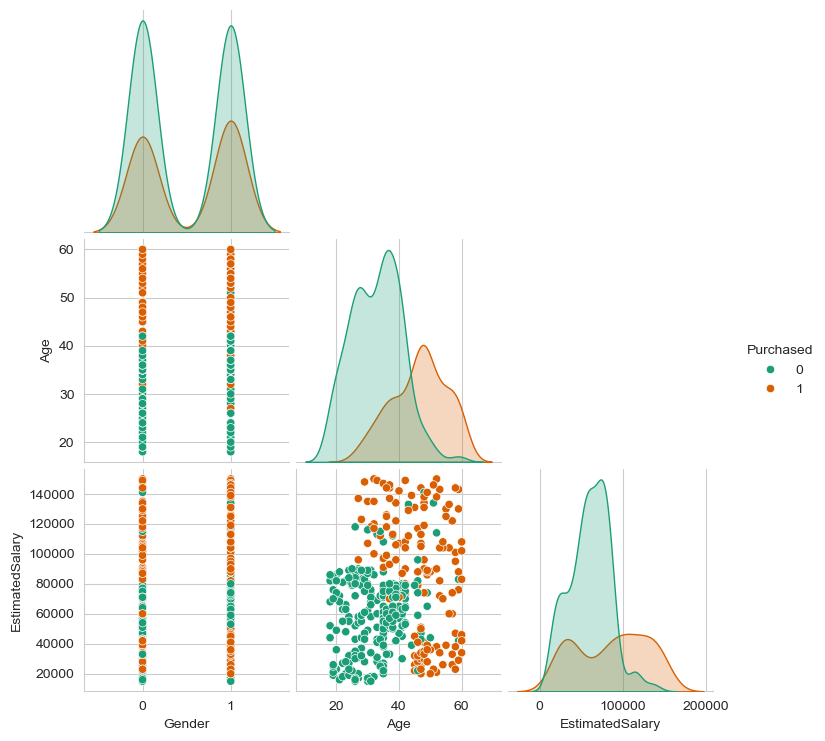

In [71]:
sns.pairplot(df , hue = 'Purchased', palette='Dark2',corner=True );

- Age & Estimated Salary vs Target

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

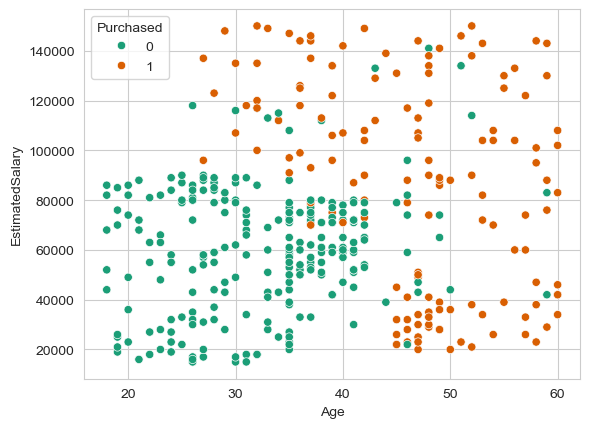

In [76]:
sns.scatterplot(x = 'Age',y = 'EstimatedSalary', data = df, hue = 'Purchased', palette ='Dark2')

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["User ID", "Purchased"]), df["Purchased"], stratify=df["Purchased"])

In [ ]:
y_train.value_counts(normalize=True).round(2)

Purchased
0    0.64
1    0.36
Name: proportion, dtype: float64

In [ ]:
y_test.value_counts(normalize=True).round(2)

Purchased
0    0.64
1    0.36
Name: proportion, dtype: float64

### Binning Age

In [82]:
# Step 1: use pd.qcut to determine the range based on the quantile
# pd.qcut(X_train['Age'], q=5)
# This is determined by pd.qcut: (17.999, 27.0] < (27.0, 35.0] < (35.0, 39.0] < (39.0, 47.0] < (47.0, 60.0]
def binning_age(age_col: pd.Series) -> pd.Series:
    return pd.cut(
        age_col,
        bins=[-np.inf, 18, 27, 35, 39, 47, 60, np.inf],
        labels=["18 and under", "19-27", "28-35", "36-39", "40-47", "48-60", "60+"],
    )

X_train["Age_Bin"] = binning_age(X_train["Age"])
X_test["Age_Bin"] = binning_age(X_test["Age"])


In [88]:
num_pipeline = make_pipeline(
                SimpleImputer(strategy="median"),
                StandardScaler()
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
    ],
    remainder='passthrough',   # 'drop' and 'passthrough'
    n_jobs=-1          # n_job = -1 means that we'll be using all processors to run in parallel.
)